# Visualization
In this notebook, we're going to explore what the model we have trained actually learned.
This involves some of the following things:
* **Verify that we actually get better while learning**
* **Look at the motifs we learn**
* What does the hidden layer tell us about the model

In [25]:
# some always important inputs
import sys
import os
import random
import time
import numpy as np
import cPickle
#import PIL

# the underlying convRBM implementation
sys.path.append(os.path.abspath('../code'))
from convRBM import CRBM
import getData as dataRead

# plotting and data handling
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# the biopython stuff
import Bio.SeqIO as sio
import Bio.motifs.matrix as mat
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import motifs as mot

## Read in the data and a previously trained model
This part of the notebook trains a convolutional RBM on the DHS data. This may take a lot of time but only once we trained it, will it be possible to do the visualization of what the model learnt.

In [2]:
# read in the model
date_string = '2016_01_27_21_27'
modelDir = '../../training/' + date_string
learner = CRBM(file_name = modelDir + '/model.pkl')

In [3]:
print learner.motifs.get_value()[0]

[[[-0.69687557  0.24344569 -1.12664127 -2.18144298  0.73494285  2.48977041
    0.15591048  0.16404465  2.46896386  2.05345416 -0.96127945]
  [ 6.33243704 -1.27839625  0.29167956 -0.28850508 -0.61714739 -1.43038738
   -1.30946636 -1.43867588 -1.17150199  1.63574731  0.36157128]
  [-1.30469668  0.65013576  3.91298819  4.42123079  1.95545244 -0.18608816
    4.76460838 -0.15726537  0.05676166 -2.28332496 -1.10248971]
  [-2.54318285  2.6316812  -0.34464321 -0.53176862  0.69624484  0.98494303
   -1.56864202  2.67858028  1.00674117  1.24937427  3.62760329]]]


### Some basic funcions to get motifs from the matrices

In [4]:
def getLetterToInt (num):
    if num == 0:
        return 'A'
    elif num == 1:
        return 'C'
    elif num == 2:
        return 'G'
    elif num == 3:
        return 'T'
    else:
        print 'ERROR: Num ' + str(num) + " not a valid char in DNA alphabet"
        return -1

def createMotifFromMatrix (matrix, alphabet=IUPAC.unambiguous_dna):
    assert matrix.shape[0] == 4
    
    # transform the matrix such that the log odds are taken away
    # matrix_ij = log(foreground/background) <=> log(foreground) - log(background)
    psm = matrix + np.log(0.25) # 0.25 if we treat all letters as equally probable
    psm = np.exp(psm)
    psm = psm / psm.sum(axis=1, keepdims=True)
    
    # make this matrix a valid motif
    counts = {}
    for row in range(4):
        counts[getLetterToInt(row)] = (psm[row]).tolist()
    motif = mot.Motif(alphabet=alphabet, instances=None, counts=counts)
    return motif


def weblogo(motif, file_format="png", version="2.8.2", **kwds): 
    from Bio._py3k import urlopen, urlencode, Request 
    frequencies = motif.format('transfac') 
    url = 'http://weblogo.threeplusone.com/create.cgi' 
    values = {'sequences': frequencies, 
                    'format': file_format.lower(), 
                    'stack_width': 'medium', 
                    'stack_per_line': '40', 
                    'alphabet': 'alphabet_dna', 
                    'ignore_lower_case': True, 
                    'unit_name': "bits", 
                    'first_index': '1', 
                    'logo_start': '1', 
                    'logo_end': str(motif.length), 
                    'composition': "comp_auto", 
                    'percentCG': '', 
                    'scale_width': True, 
                    'show_errorbars': False, 
                    'logo_title': '', 
                    'logo_label': '', 
                    'show_xaxis': False, 
                    'xaxis_label': '', 
                    'show_yaxis': False, 
                    'yaxis_label': '', 
                    'yaxis_scale': 'auto', 
                    'yaxis_tic_interval': '1.0', 
                    'show_ends': False, 
                    'show_fineprint': False, 
                    'color_scheme': 'color_auto', 
                    'symbols0': '', 
                    'symbols1': '', 
                    'symbols2': '', 
                    'symbols3': '', 
                    'symbols4': '', 
                    'color0': '', 
                    'color1': '', 
                    'color2': '', 
                    'color3': '', 
                    'color4': '', 
                    } 
    values.update(dict((k, "" if v is False else str(v)) for k, v in kwds.items()))
    data = urlencode(values).encode("utf-8")
    req = Request(url, data)
    response = urlopen(req)
    return response


def getLogoListFrom4DMatrix(matrix):
    images = []
    for motifNum in range(matrix.shape[0]):
        m = createMotifFromMatrix(matrix[motifNum,0])
        reader = weblogo(m)
        images.append(plt.imread(reader))
    return images

import math
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))

def getObserverIndex():
    count = 0
    for obs in learner.observers:
        if "motif" in obs.name.lower():
            return count
        count += 1

In [5]:
learner.printHyperParams()
print len(learner.observers[getObserverIndex()].scores)

{'learning_rate': 1e-05,
 'motif_length': 11,
 'number_of_motifs': 15,
 'pooling_factor': 5}
501


## Make a video from the motifs in which we have a subplot of all motifs per frame!
For that, we have to find out how we can simply get the image without writing it to disk first.
Then, we can use python multimedia capabilities for some nice plotting!

In [6]:
# get the logos for all scores during training
observerIndex = getObserverIndex()
logosOverTime = []
numberOfEpochs = 200
frames = min(len(learner.observers[observerIndex].scores), numberOfEpochs)
for timeSlice in range(frames):
    allMotifsPerSlice = learner.observers[observerIndex].scores[timeSlice]
    logosOverTime.append(getLogoListFrom4DMatrix(allMotifsPerSlice))
    print "Got Logos for Time/Epoch " + str(timeSlice)

Got Logos for Time/Epoch 0
Got Logos for Time/Epoch 1
Got Logos for Time/Epoch 2
Got Logos for Time/Epoch 3
Got Logos for Time/Epoch 4
Got Logos for Time/Epoch 5
Got Logos for Time/Epoch 6
Got Logos for Time/Epoch 7
Got Logos for Time/Epoch 8
Got Logos for Time/Epoch 9
Got Logos for Time/Epoch 10
Got Logos for Time/Epoch 11
Got Logos for Time/Epoch 12
Got Logos for Time/Epoch 13
Got Logos for Time/Epoch 14
Got Logos for Time/Epoch 15
Got Logos for Time/Epoch 16
Got Logos for Time/Epoch 17
Got Logos for Time/Epoch 18
Got Logos for Time/Epoch 19
Got Logos for Time/Epoch 20
Got Logos for Time/Epoch 21
Got Logos for Time/Epoch 22
Got Logos for Time/Epoch 23
Got Logos for Time/Epoch 24
Got Logos for Time/Epoch 25
Got Logos for Time/Epoch 26
Got Logos for Time/Epoch 27
Got Logos for Time/Epoch 28
Got Logos for Time/Epoch 29
Got Logos for Time/Epoch 30
Got Logos for Time/Epoch 31
Got Logos for Time/Epoch 32
Got Logos for Time/Epoch 33
Got Logos for Time/Epoch 34
Got Logos for Time/Epoch 35
Go

(30, 1, 4, 11)
5.0 6.0
in init
30


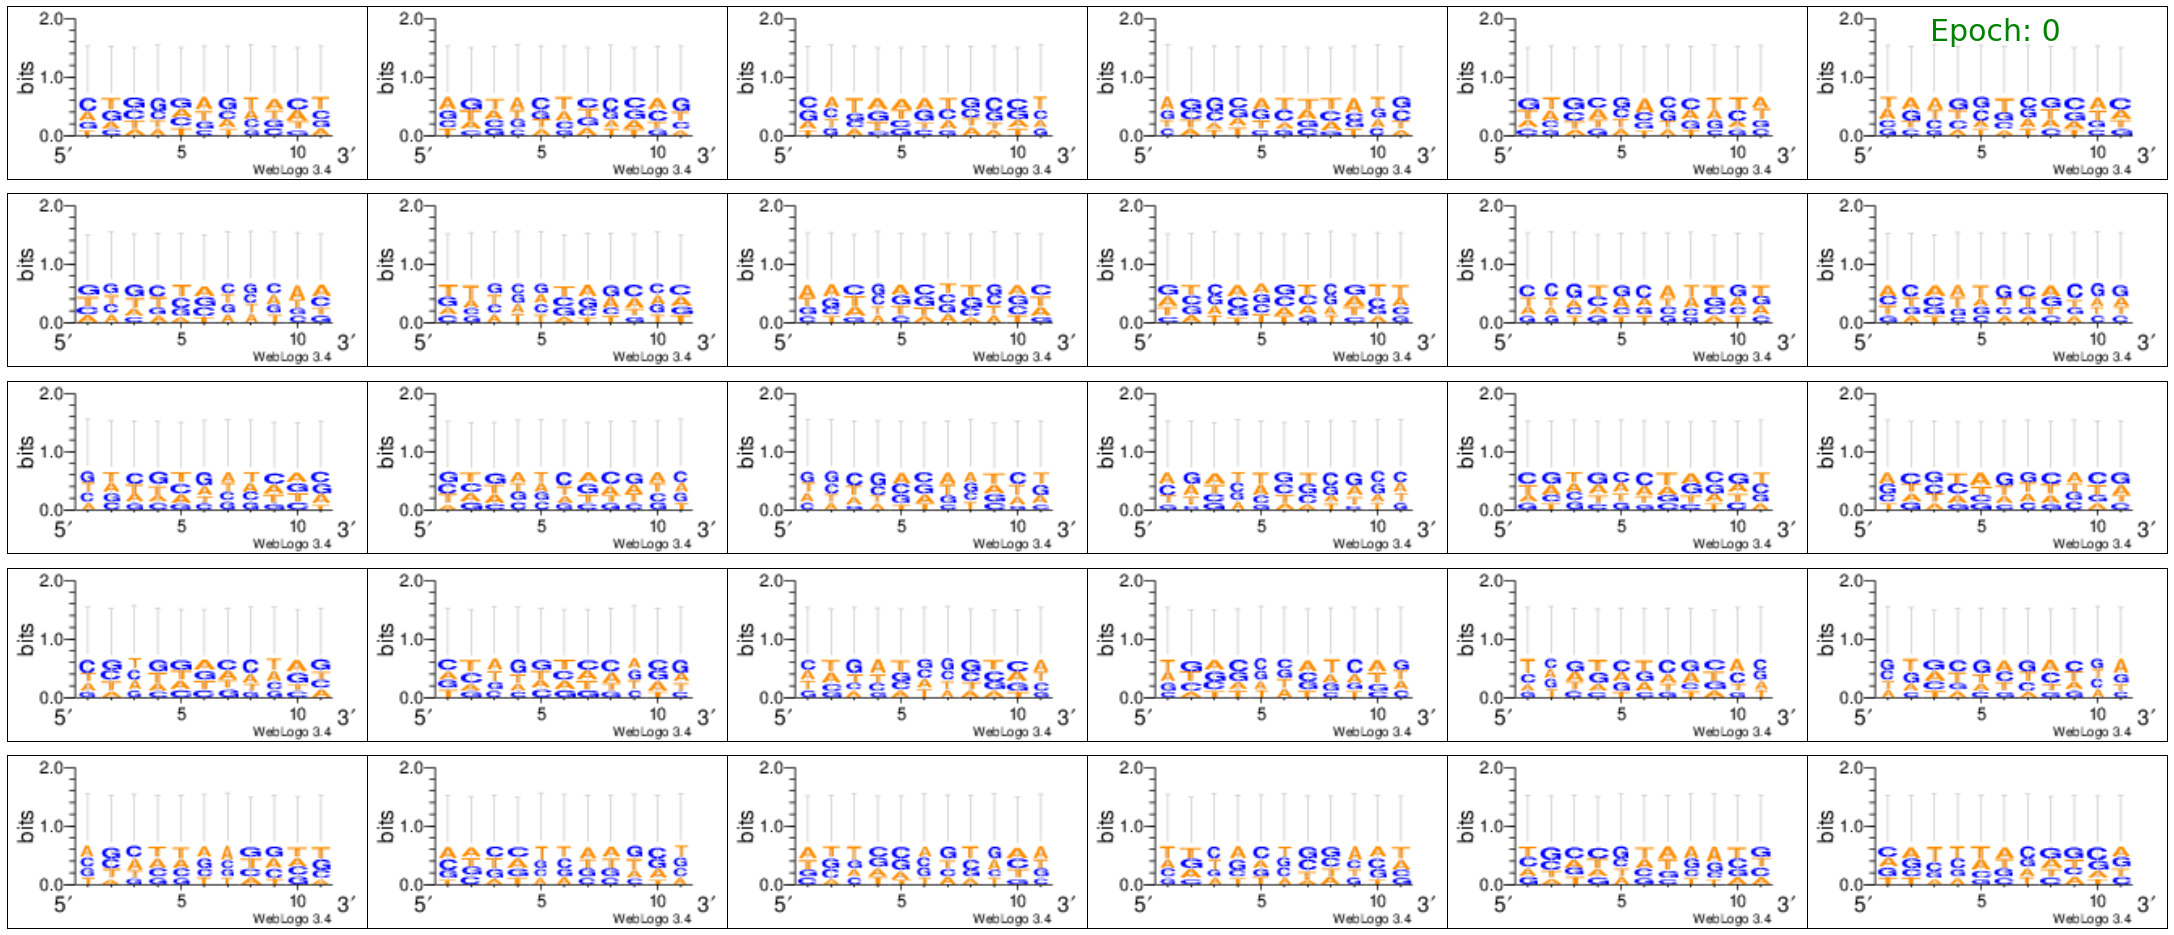

In [62]:
from matplotlib import animation

fig = plt.figure(figsize=(30,13))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
frame_text = fig.text(0.95, 0.95,
                      'Epoch: ' + str(0),
                      verticalalignment='bottom',
                      horizontalalignment='right',
                      color='green', fontsize=30)
allMotifsOverTime = learner.observers[observerIndex].scores
print allMotifsOverTime[0].shape

x, y = bestSplit(allMotifsOverTime[0].shape[0])
print x, y
axesList = []

def init():
    print "in init"
    for i in range(allMotifsOverTime[0].shape[0]):
        ax = fig.add_subplot(x, y, i+1, xticks=[], yticks=[])
        im = ax.imshow(logosOverTime[0][i])
        axesList.append(im)
    print len(axesList)
        
def printFrame(frameNr):
    numMotifs = allMotifsOverTime[frameNr].shape[0]
    for motif in range(numMotifs):
        axesList[motif].set_data(logosOverTime[frameNr][motif])
        #ax.imshow(logosOverTime[frameNr][motif])
    frame_text.set_text('Epoch: ' + str(frameNr))

anim = animation.FuncAnimation(fig,
                               printFrame,
                               init_func=init,
                               frames=frames,
                               interval=200, repeat=True)
#anim.save(modelDir + '/motifChanges.mp4', fps=10)
plt.show()

## Visualize motif hits

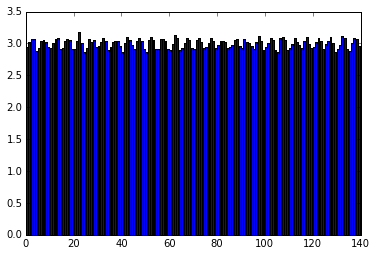

In [67]:
%matplotlib inline

def getObserverIndex(string):
    count = 0
    for obs in learner.observers:
        if string in obs.name.lower():
            return count
        count += 1

def plotMotifHitsForFrame (frameNr):
    obsIdx = getObserverIndex("hit")
    scores = learner.observers[obsIdx].scores[frameNr].sum(axis=0)
    scores = scores.reshape(-1)
    plt.bar(range(0,scores.shape[0]), scores)
    plt.show()
    
plotMotifHitsForFrame(499)

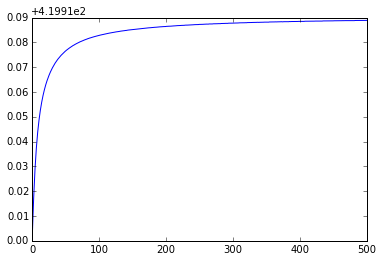

In [69]:

idx = getObserverIndex("hit")
l = []
for i in range(len(learner.observers[idx].scores)):
    l.append(learner.observers[idx].scores[i].sum())

plt.plot(l)
plt.savefig('motifHitsOverTime.png', dpi=400)

In [27]:
# TEMP
fig = plt.figure(figsize=(30,13))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
x, y = bestSplit(allMotifsOverTime[0].shape[0])
print x, y
observerIndex = getObserverIndex("motif")

def showFrame(frameNr):
    numMotifs = allMotifsOverTime[frameNr].shape[0]
    allMotifsForFrame = learner.observers[observerIndex].scores[frameNr]
    logos = getLogoListFrom4DMatrix(allMotifsPerSlice)
    for motif in range(numMotifs):
        ax = fig.add_subplot(x, y, motif+1, xticks=[], yticks=[])
        ax.imshow(logos[motif])
    plt.savefig('learnedMotifs.png')
showFrame(len(learner.observers[observerIndex].scores)-1)

5.0 6.0
